# Homework 2
### ASTR518
### Noah Franz

In [178]:
#imports
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimezoneInfo

import astroplan as planner
from astroplan.plots import plot_airmass 


# Problem 1

# Problem 2

In [179]:
@dataclass
class Telescope:
    
    name:str
    area:float
    throughput:float
    gain:float
    n_pix:float
    dark_noise:float
    read_noise:float
    q: float # quantum efficiency
    target_fov:float = 1 # assume target is point source that is 1" on sky
    sky_brightness:float = 22 # the sky brightness in mag/arcsec^2
    
    def __post_init__(self, *args, **kwargs):
        
        self.sky_scatter = self.throughput * self.f_V(self.sky_brightness).to(u.ct/u.s/u.arcsec**2) / self.n_pix
    
    def f_V(
            self,
            mag:float,
            lambda_eff:u.Quantity=0.545*u.um, # for V mag
            f0:u.Quantity=363.1e-11*u.erg/(u.cm**2 * u.s * u.AA) # for V mag
        ) -> u.Quantity:
        
        return f0*10**(-0.4*mag) * self.area * lambda_eff**2 / (c.h*c.c) *u.ct/u.arcsec**2
    
    
    def obst(self, mag, SNR_goal=5, **kwargs):
        N_star = self.throughput*self.q*self.f_V(mag, **kwargs).to(u.ct/u.s/u.arcsec**2).value
        
        a = N_star**2
        b = -SNR_goal**2 * (N_star + self.dark_noise*self.n_pix/3600 + self.q*self.sky_scatter.value*self.n_pix*self.target_fov)
        c = -SNR_goal**2 * self.read_noise * self.n_pix

        return np.roots((a,b,c)).max()

In [180]:
n_pix_bok = 4 * (4096**2) * u.pix
A_Bok = np.pi*(2.29*u.m/2)**2
T_bok = 0.8578
g_bok = 2
D_bok = 3 # electrons / pixel / hour
n_pix_bok = (4096**2) #4*(4096**2)
R_bok = 12

Bok = Telescope(
    name="Bok",
    area=A_Bok,
    throughput=T_bok,
    gain=g_bok,
    n_pix=n_pix_bok,
    dark_noise=D_bok,
    read_noise=R_bok,
    q=0.90
)

Bok

Telescope(name='Bok', area=<Quantity 4.11870651 m2>, throughput=0.8578, gain=2, n_pix=16777216, dark_noise=3, read_noise=12, q=0.9, target_fov=1, sky_brightness=22)

In [181]:
A_kuiper = np.pi * (1.54*u.m)**2

T_kuiper = T_bok

g_kuiper = 3.1
D_kuiper = 16.6 # electrons / pixel / hour
n_pix_kuiper = 4096 * 4097
R_kuiper = 5

Kuiper = Telescope(
    name = 'Kuiper 61"',
    area = A_kuiper,
    throughput = T_kuiper,
    gain = g_kuiper,
    n_pix = n_pix_kuiper,
    dark_noise = D_kuiper,
    read_noise = R_kuiper,
    q=0.88
)

Kuiper

Telescope(name='Kuiper 61"', area=<Quantity 7.45060114 m2>, throughput=0.8578, gain=3.1, n_pix=16781312, dark_noise=16.6, read_noise=5, q=0.88, target_fov=1, sky_brightness=22)

In [182]:
# part (f)


f_bok = Bok.f_V(22).to(u.ct/u.s/u.arcsec**2)
f_bok

<Quantity 354.40787805 ct / (s arcsec2)>

In [183]:
Bok.sky_scatter

<Quantity 1.81204723e-05 ct / (s arcsec2)>

In [184]:
# part (g)

Bok.obst(mag=15)

0.41102808237735405

In [185]:
print(Kuiper.sky_scatter)

Kuiper.obst(mag=15)

3.277132231807387e-05 ct / (s arcsec2)


0.1500424569702492

# Problem 3

_Potential Target 1 : AT2024pvu (Confirmed TDE but old!)_
* Discovery Date: July 10, 2024 (This is old :( )
* Coordinates: 23:31:11.903 +22:15:32.14
* Magnitude between 17 and 19 (17 as of 08/26, that was a month ago so likely will just capture host contamination at magnitude ~19)
* z ~ 0.048
* TNS Link: https://www.wis-tns.org/object/2024pvu

_Potential Target 2 : AT2024ule (unconfirmed, but suspected, TDE)_
* Coordinates: 08:14:27.141 +09:00:01.47
* Magnitude: 18.84 on 10/10
* z ~ Unknown
* TNS Link: https://www.wis-tns.org/object/2024ule

_Potential Target 3 : AT 2024vpg (unconfirmed, but suspected, TDE)_
* Coordinates: 19:47:23.194 +57:35:28.84
* Magnitude 19.7 on 09/22, probably still brightening!
* Z ~ Unknown
* TNS Link: https://www.wis-tns.org/object/2024vpg

### Part 3a/b/c

In [186]:
obs = planner.Observer.at_site('mtbigelow')
obs_date = Time("2024-10-19 02:00:00", format="iso") + 7*u.hour # we are observing on the night of Oct 18, 2024 - Oct 19, 2024, converted to utc
tz = TimezoneInfo(utc_offset=-7*u.hour)

In [187]:
pvu_coords = SkyCoord("23:31:11.903", "+22:15:32.14", unit=("hour", "deg"))
pvu = planner.FixedTarget(name='AT2024pvu', coord=pvu_coords)

ule_coords = SkyCoord("08:14:27.141", "+09:00:01.47", unit=("hour", "deg"))
ule = planner.FixedTarget(name='AT2024ule', coord=ule_coords)

vpg_coords = SkyCoord("19:47:23.194", "+57:35:28.84", unit=("hour", "deg"))
vpg = planner.FixedTarget(name='AT2024vpg', coord=vpg_coords)

targets = dict(
    AT2024pvu = pvu,
    AT2024ule = ule,
    AT2024vpg = vpg
)

In [188]:
for name, t in targets.items():
    rise_time = obs.target_rise_time(obs_date, t) + 5*u.minute
    set_time = obs.target_set_time(obs_date, t) - 5*u.minute
    
    print(f"{name} is up from {rise_time.iso} - {set_time.iso}")

AT2024pvu is up from 2024-10-18 22:08:09.906 - 2024-10-19 11:57:15.174
AT2024ule is up from 2024-10-19 07:27:45.672 - 2024-10-19 20:01:28.276
AT2024vpg is up from                     ——— -                     ———


In [189]:
sunset_tonight = obs.sun_set_time(obs_date, which='nearest')
sunrise_tonight = obs.sun_rise_time(obs_date, which='nearest')

sunset_tonight.iso, sunrise_tonight.iso

('2024-10-19 00:41:54.550', '2024-10-19 13:34:14.868')

In [190]:
for name, t in targets.items():
    rise_time = obs.target_rise_time(obs_date, t) + 5*u.minute
    set_time = obs.target_set_time(obs_date, t) - 5*u.minute
    
    start = np.max([sunset_tonight, rise_time])
    stop = np.min([sunrise_tonight, set_time])
    
    print(f"{name} is available to observe from {start.iso} - {stop.iso}")

AT2024pvu is available to observe from 2024-10-19 00:41:54.550 - 2024-10-19 11:57:15.174
AT2024ule is available to observe from 2024-10-19 07:27:45.672 - 2024-10-19 13:34:14.868
AT2024vpg is available to observe from                     ——— -                     ———


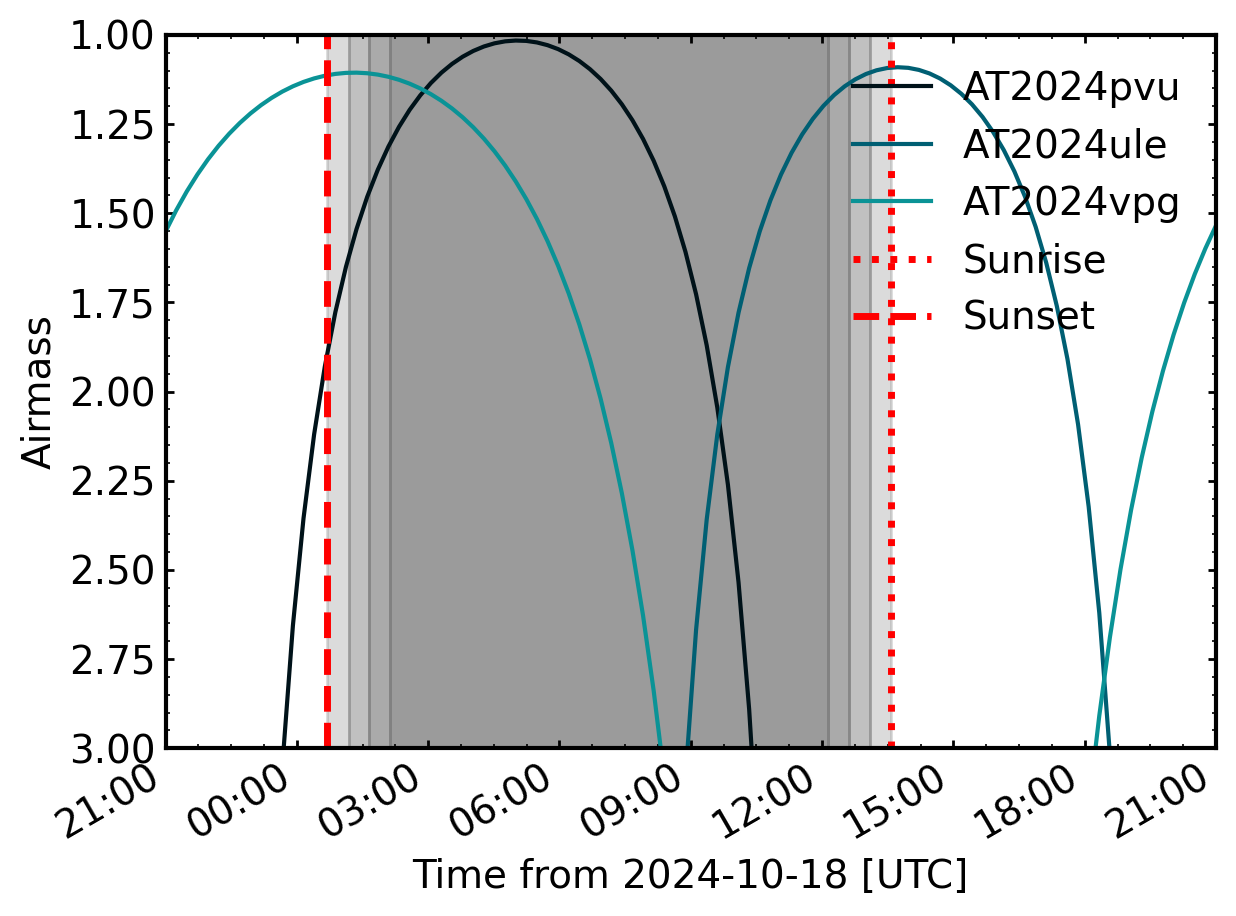

In [191]:
for name, t in targets.items():
    plot_airmass(t, obs, obs_date, brightness_shading=True) 

plt.axvline(sunrise_tonight.plot_date, color='r', linestyle=':', label='Sunrise')
plt.axvline(sunset_tonight.plot_date, color='r', linestyle='--', label='Sunset')

plt.legend(loc=1, bbox_to_anchor=(1, 1)) 

plt.show() 

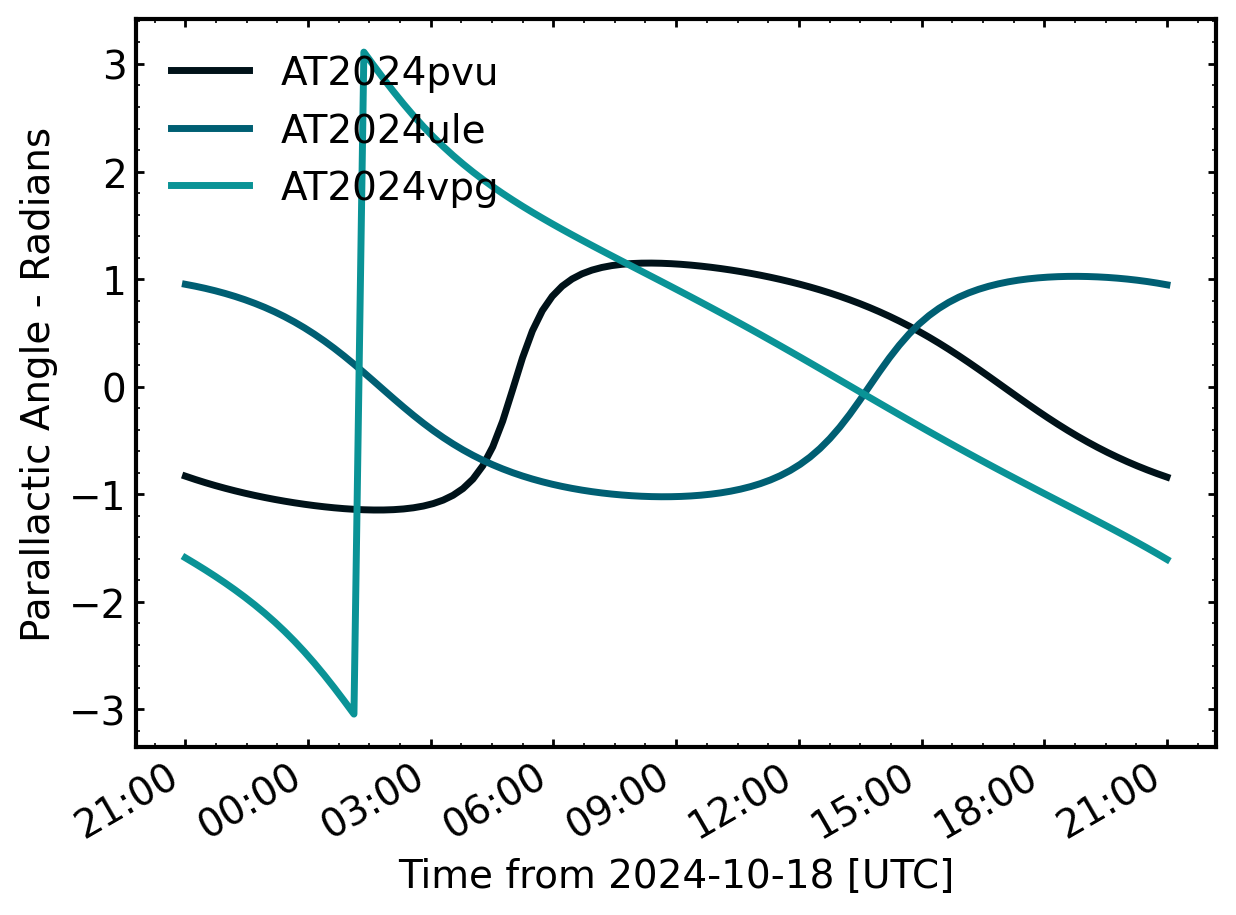

In [192]:
import matplotlib.pyplot as plt 

from astroplan.plots import plot_parallactic 

for name, t in targets.items():
    plot_parallactic(t, obs, obs_date)
    
plt.legend(loc=2) 

plt.show() 


### Part 3d

Now plan an observing schedule for these three targets

First step is to compute how long we need to be on each of these targets for SNR 5

In [195]:
target_mags = dict(
    AT2024pvu = 19,
    AT2024ule = 18.8,
    AT2024vpg = 19
)

target_time = dict(
    AT2024pvu = None,
    AT2024ule = None,
    AT2024vpg = None
)
SNR_wanted = 5

tele = Bok

for name, target_mag in target_mags.items():
    t = tele.obst(target_mag, SNR_goal=SNR_wanted)
    target_time[name] = t
    print(f"{name} must be observed for {t} s for SNR={SNR_wanted}")

AT2024pvu must be observed for 16.37256454081503 s for SNR=5
AT2024ule must be observed for 13.61677915552362 s for SNR=5
AT2024vpg must be observed for 16.37256454081503 s for SNR=5


Since these exposure times are so short, a good observing plan would be something like (Note: all times are in UTC)

1. AT2024vpg at the beginning of the night from 01:30 to 02:00
2. AT2024pvu anytime between 02:00 and 07:00
3. AT2024ule from 12:00 to 12:30

### Part 3e

/tmp/ipykernel_3141983/1046823247.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


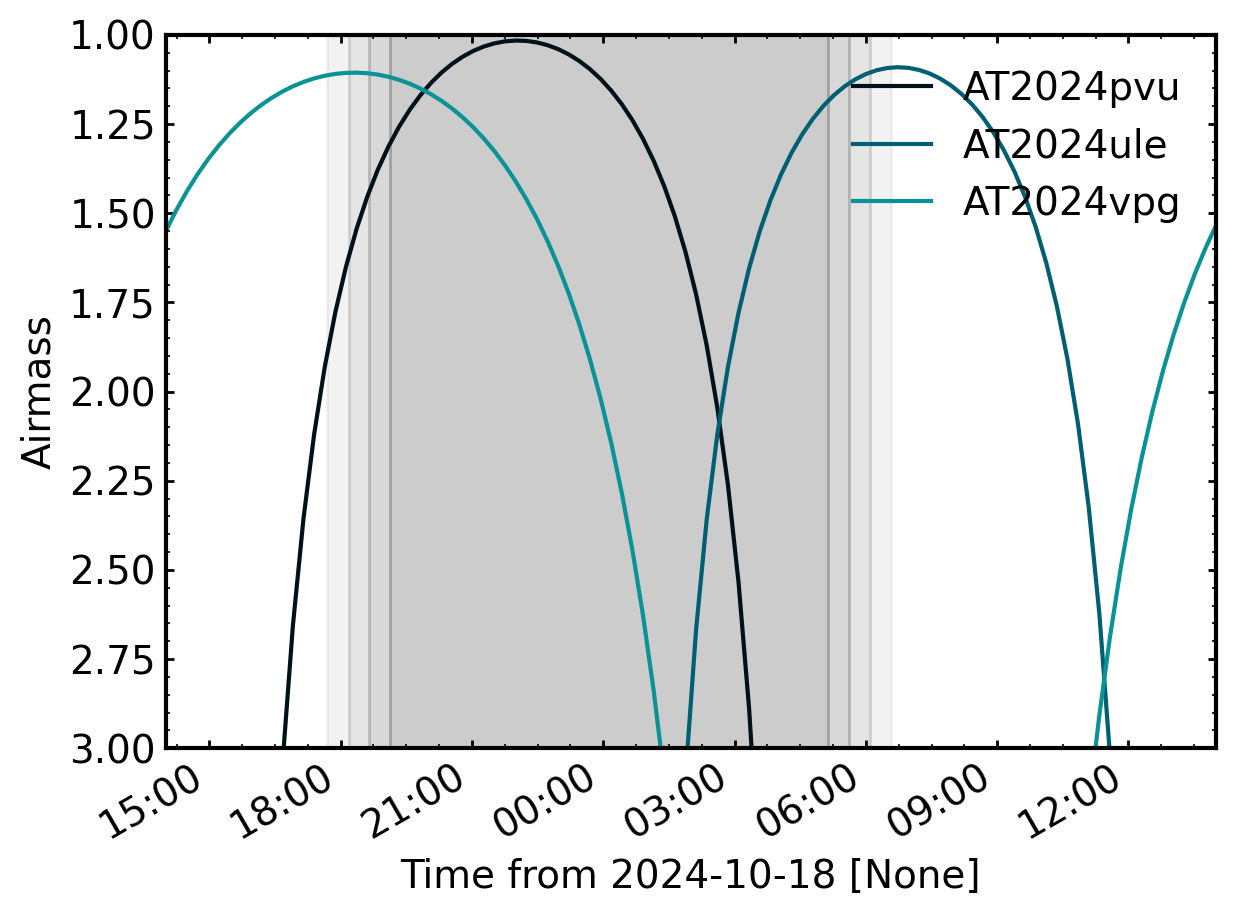

In [196]:
fig, ax = plt.subplots()

ax = plot_airmass(
    list(targets.values()), 
    obs, 
    obs_date.to_datetime(timezone=tz), 
    ax=ax, 
    use_local_tz=True, 
    brightness_shading=True
) 

ax.legend(loc=1, bbox_to_anchor=(1, 1)) 

fig.show() 

# Problem 4